In [1]:
import numpy as np
import pandas as pd

## Load in the dataset, make sure to change the path

In [6]:
sample_data = pd.read_csv('sample_dataset.csv')
sample_data.head()

,author,content,class
0,TONYLYNNNNN,Gonna be a nice Xmas Eve! #MerryXmas https://t...,1
1,JFHUJ,"@Laurentiius All purpose, Gold Medal sifted fl...",0
2,BRIANAREGLAND,anybody got a place in ATL for me to stay at! ...,1
3,DOROTHIEBELL,Tonganoxie police: Middle school girl sexually...,1
4,RANDALL_COOKE,MT @ChristiChat: #WakeUpAmerica - FOUR AMERICA...,1


### Removing stop words from the content column

In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
sample_data['content'] = sample_data['content'].apply(
    lambda x: ' '.join([word for word in (str(x)).split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\omril\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

#### Tokenizing the text and author columns

In [14]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sample_data['content'])
sample_data['content'] = tokenizer.texts_to_sequences(sample_data['content'])

In [15]:
author_tokenizer = tf.keras.preprocessing.text.Tokenizer()
author_tokenizer.fit_on_texts(sample_data['author'])
sample_data['author'] = author_tokenizer.texts_to_sequences(sample_data['author'])

#### Determine the average lengths of the text and author arrays

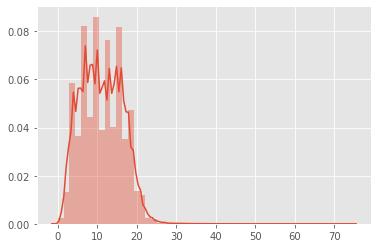

In [17]:
X_lens = [len(x) for x in sample_data['content'].values]
X_lens = np.array(X_lens)
sns.distplot(X_lens)

In [18]:
print(np.mean(X_lens), np.std(X_lens))

11.114680136792897 5.187815129714854


In [19]:
MAX_CONTENT_LENGTH = 21
np.unique((X_lens >= MAX_CONTENT_LENGTH), return_counts=True)

(array([False,  True]), array([154961,   4404], dtype=int64))

In [20]:
(154961)/(154961+4404)

0.9723653248831299

C:\Users\omril\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


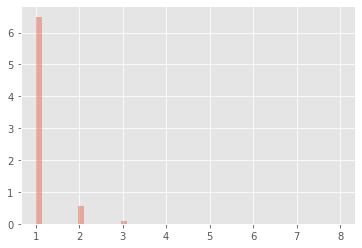

In [22]:
Y_lens = [len(x) for x in sample_data['author'].values]
Y_lens = np.array(Y_lens)
sns.distplot(Y_lens)

In [23]:
print(np.mean(Y_lens), np.std(Y_lens))

1.1038998525397672 0.348863416599461


In [24]:
MAX_AUTHOR_LENGTH = 3
np.unique((Y_lens >= MAX_AUTHOR_LENGTH), return_counts=True)

(array([False,  True]), array([157338,   2027], dtype=int64))

In [25]:
labels = sample_data.pop('class')

#### Split test and train, then pad the arrays to make them uniform length

In [26]:
X_train, X_test, y_train, y_test = train_test_split(sample_data, labels)

In [27]:
X_train_author = X_train.pop('author')
X_test_author = X_test.pop('author')

X_train_content = X_train.pop('content')
X_test_content = X_test.pop('content')

In [28]:
X_train_author = tf.keras.preprocessing.sequence.pad_sequences(X_train_author,
                                                               maxlen=MAX_AUTHOR_LENGTH,
                                                               padding='post',
                                                               truncating='post')
X_test_author = tf.keras.preprocessing.sequence.pad_sequences(X_test_author,
                                                              maxlen=MAX_AUTHOR_LENGTH,
                                                              padding='post',
                                                              truncating='post')

In [29]:
X_train_content = tf.keras.preprocessing.sequence.pad_sequences(X_train_content,
                                                                maxlen=MAX_CONTENT_LENGTH,
                                                                padding='post',
                                                                truncating='post')
X_test_content = tf.keras.preprocessing.sequence.pad_sequences(X_test_content,
                                                               maxlen=MAX_CONTENT_LENGTH,
                                                               padding='post',
                                                               truncating='post')

#### Create CNN model layers

In [30]:

author_input = tf.keras.layers.Input(shape=(MAX_AUTHOR_LENGTH,), name = 'author_input')
author_embed = tf.keras.layers.Embedding(len(author_tokenizer.index_word)+1, 50, input_length=MAX_AUTHOR_LENGTH, name='author_embedding')(author_input)
author_conv = tf.keras.layers.Conv1D(256, 3, name='author_conv')(author_embed)
author_pool = tf.keras.layers.GlobalMaxPooling1D(name='author_pooling')(author_conv)
vector_input = tf.keras.layers.Input(shape=(21,), name='twitter_input')
concat = tf.keras.layers.concatenate([author_pool, vector_input])
dense_100 = tf.keras.layers.Dense(100, activation='relu')(concat)
dense_50 = tf.keras.layers.Dense(50, activation='relu')(dense_100)
out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_50)
model = tf.keras.models.Model(inputs=[author_input, vector_input], outputs=out_layer)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
author_input (InputLayer)       [(None, 3)]          0                                            
__________________________________________________________________________________________________
author_embedding (Embedding)    (None, 3, 50)        3498900     author_input[0][0]               
__________________________________________________________________________________________________
author_conv (Conv1D)            (None, 1, 256)       38656       author_embedding[0][0]           
__________________________________________________________________________________________________
author_pooling (GlobalMaxPoolin (None, 256)          0           author_conv[0][0]                
_______________________________________________________________________________________

In [32]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                            patience=5,
                                            mode='max',
                                          restore_best_weights=True)
history = model.fit([X_train_author, X_train_content, X_train],
                     y_train,
                     epochs=20,
                     batch_size=8192,
                     validation_data=(
                           [X_test_author, X_test_content, X_test],
                            y_test
                     ),
callbacks=[callback])

Epoch 1/20
15/15 [==============================] - 1s 70ms/step - loss: 86.3313 - accuracy: 0.8052 - val_loss: 84.2683 - val_accuracy: 0.8044
Epoch 2/20
15/15 [==============================] - 1s 69ms/step - loss: 76.7580 - accuracy: 0.8241 - val_loss: 76.3801 - val_accuracy: 0.8258
Epoch 3/20
15/15 [==============================] - 1s 72ms/step - loss: 68.1747 - accuracy: 0.8476 - val_loss: 69.4646 - val_accuracy: 0.8467
Epoch 4/20
15/15 [==============================] - 1s 70ms/step - loss: 60.5043 - accuracy: 0.8661 - val_loss: 63.6450 - val_accuracy: 0.8588
Epoch 5/20
15/15 [==============================] - 1s 70ms/step - loss: 53.8762 - accuracy: 0.8835 - val_loss: 58.3355 - val_accuracy: 0.8721
Epoch 6/20
15/15 [==============================] - 1s 70ms/step - loss: 48.1646 - accuracy: 0.8986 - val_loss: 53.8794 - val_accuracy: 0.8845
Epoch 7/20
15/15 [==============================] - 1s 69ms/step - loss: 43.3196 - accuracy: 0.9115 - val_loss: 49.8114 - val_accuracy: 0.8961

In [33]:
preds = model.predict([X_test_author, X_test_content, X_test])

In [34]:
model.evaluate([X_test_author, X_test_content, X_test], y_test)

1246/1246 [==============================] - 1s 436us/step - loss: 24.8809 - accuracy: 0.9583


[24.880929946899414, 0.9583103060722351]

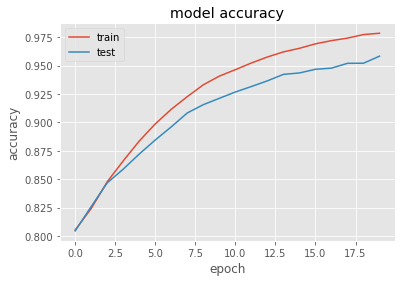

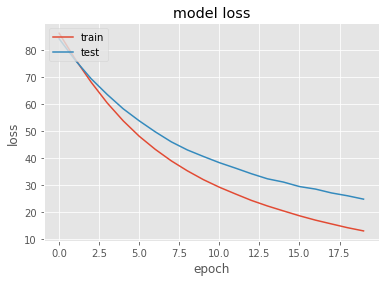

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()